# Perfomance Test

Here we compare two implementations of the Hankel Function:
- Hankel: https://hankel.readthedocs.io/en/latest/index.html 
- Hankl: https://hankl.readthedocs.io/en/latest/

The second one was created specifically for power spectrum functions

In [1]:
import hankel
from hankel import HankelTransform     # Import the basic class
print("Using hankel v{}".format(hankel.__version__))

Using hankel v1.2.1


In [2]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

Using hankel v1.1.0


## Matter Power Spectrum: CAMB

We use CAMB to have a power spectrum as an example.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/camb


### Get Matter power spectra for a given cosmology
Taken from notebook example: https://camb.readthedocs.io/en/latest/CAMBdemo.html

In [4]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.3], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=500, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=500, npoints = 200)



Note: redshifts have been re-sorted (earliest first)


In [5]:
print(results.get_sigma8())


[0.68425699 0.80251083]


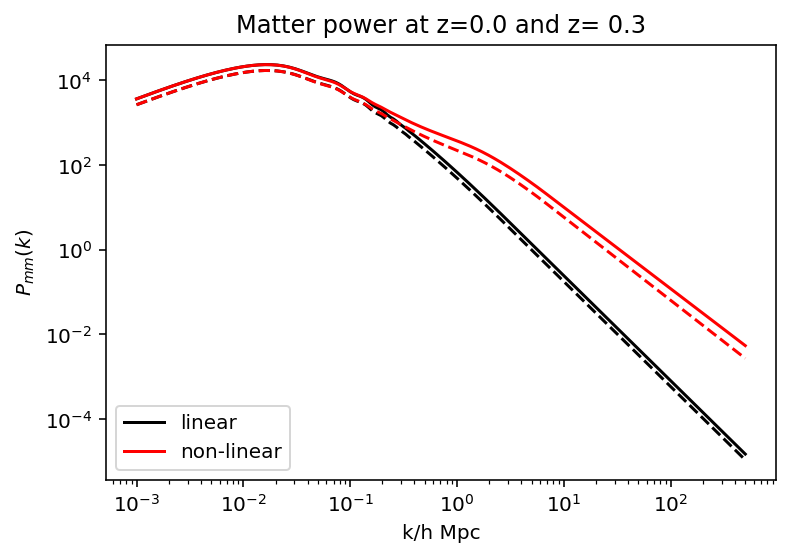

In [6]:
for i, (redshift, line) in enumerate(zip(z_lin,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z_lin));

# Hankel Transformations

The hankel transformations are important for several reasons. 
- First, the first order hankel transformation of the $P_{mm}(k)$ is $\xi_{mm} (R)$ matter correlation functions in real space. After some test perfomed by Chiara, she showed that is  the most accurate computation of $\xi_{mm}$. 
- Second, applying a second order hankel transformation we can estimate $\gamma_t (\theta)$ directly. See Equation 12, https://arxiv.org/pdf/0910.1361.pdf

In [7]:
eTimes = dict()

In [8]:
# at redshift 0.3
pk = pk_nonlin[1]
k = kh_nonlin

Now, this was the linear Matter Power Spectrum, to get the Galaxy Power Spectrum multipoles we will use Kaiser’s formula:
$$
P(k, \mu) = (b+f\mu^2) ^ 2 P_lin(k)
$$

In [9]:
def get_multipoles(pk, b, f):

    p0 = (b*b + 2.0 * b *f / 3.0 + f*f/5.0 ) * pk

    p2 = (4.0*b*f/3.0 + 4.0*f*f/7.0) * pk

    p4 = (8.0* f*f / 35.0) * pk

    return p0, p2, p4

In [10]:
P0, P2, P4 = get_multipoles(pk, b=2.0, f=0.5)


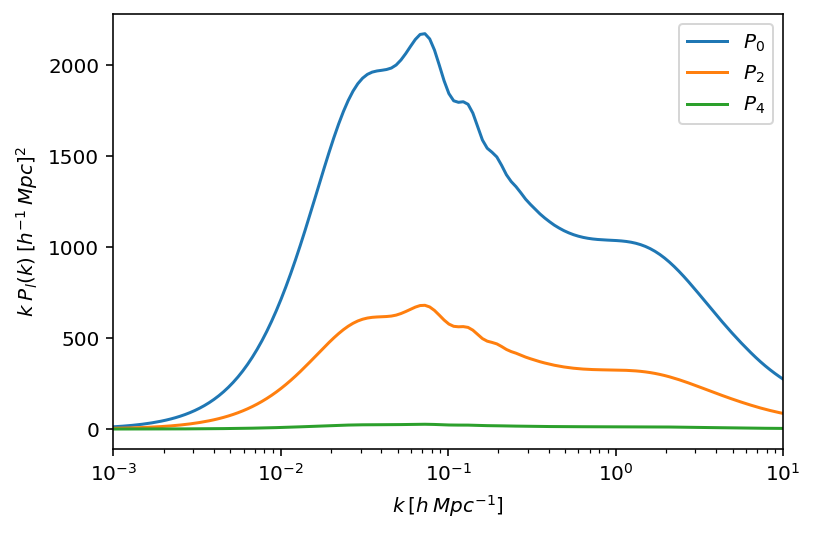

In [11]:
plt.semilogx(k, k * P0, label=r'$P_{0}$')
plt.semilogx(k, k * P2, label=r'$P_{2}$')
plt.semilogx(k, k * P4, label=r'$P_{4}$')
plt.xlabel(r'$k \: [h\: Mpc^{-1}]$')
plt.ylabel(r'$k\; P_{l}(k) \: [h^{-1}\: Mpc]^{2}$')
plt.xlim(1e-3, 10)
plt.legend()
plt.show()

In [12]:
# Using Hankl - a code created to cosmology computations
#  https://hankl.readthedocs.io/en/latest/examples.html

t0 = time()
s, xi0 = hankl.P2xi(k, pk, l=0)

eTimes['Hankl'] = [(time()-t0)*1000]
print('It takes %.3f msec'%(eTimes['Hankl'][0]))

It takes 1.932 msec


In [13]:
# Using Hankl - a code created to cosmology computations
#  https://hankl.readthedocs.io/en/latest/examples.html

t0 = time()
s, xi2 = hankl.P2xi(k, pk, l=2)

eTimes['Hankl'] += [(time()-t0)*1000]
print('It takes %.3f msec'%(eTimes['Hankl'][0]))

It takes 1.932 msec


/global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


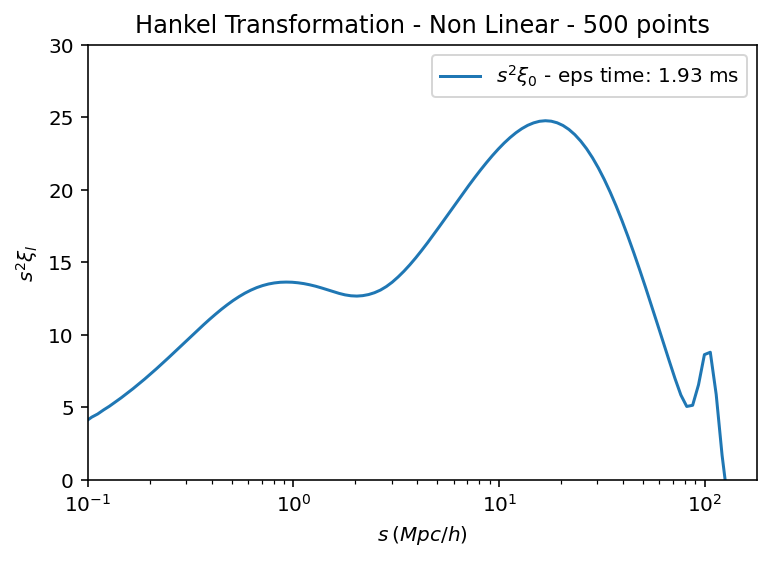

In [14]:
# plt.loglog()
plt.xscale('log')
plt.plot(s, s*s*xi0, label=r'$s^{2}\xi_{0}$ - eps time: %.2f ms'%eTimes['Hankl'][0])
# plt.plot(s, s*s*xi2, label=r'$s^{2}\xi_{2}$ - eps time: %.2f ms'%eTimes['Hankl'][1])
plt.xlim(0.1,180)
plt.ylim(-0,30)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.title('Hankel Transformation - Non Linear - 500 points')
plt.show()

## Averaged $\gamma_t$

According to Jeong, Komatsu and Jain 2009 the averaged galaxy-galaxy $\gamma_t (R) $ is:
<br>
$$
\left< \gamma_t(R, z_L) \right> = \frac{\rho_0}{\Sigma_c (z_L)} \int \frac{k dk}{2\pi} P_{hm}(k, z_L) J_2(kR) 
$$

which is not the same as applying the Hankel transformation implemented on [`hankl.P2xi`](https://hankl.readthedocs.io/en/latest/api.html#hankl.P2xi). Altough we can't simply take the second index of the matter power spectrum we can stil use the Hankel transform with a proper transformation.

Using the definition [`hank.FFTLog`](https://hankl.readthedocs.io/en/latest/api.html#hankl.FFTLog) with `q=-1` we can find a proper transformation of the Hankel transformation of the function $F(x)$:
$$
\frac{\rho_0}{\Sigma_c (z_L)} \int \frac{k dk}{2\pi} P_{hm}(k, z_L) J_2(kR)  \Rightarrow \int F(k) J_2(kR) (kR)^{-q} R dk
$$
Which basically is:
$$
F(k) = \frac{\rho_0}{\Sigma_c (z_L)} \frac{1} {2\pi} P_{hm}(k)
$$

The power spectrum with some constant factors.

In [15]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

omega_m  = cosmo.Om0
h=cosmo.H0.value/100.
const = 1.67e-7 * (omega_m * h**2) # /Mpc^2

def compute_beta(zl, zs, cosmo):
    dl, ds = cosmo.angular_diameter_distance(np.array([zl, zs])).value
    dls = cosmo.angular_diameter_distance_z1z2(zl, zs).value
    return dl, dls/ds

def avg_gamma_t(k, P, l=2, z_lens=0., z_source_eff=1., cosmo=cosmo):
    """ Compute the average gamma_t
    
    Formula 12 from Jeong, Komatsu and Jain 2009
    """
    # compute hankel transformation of the matter power spectrum
    r, f = hankl.FFTLog(k, P * k ** 0.5, q=0, mu=l + 0.5)
    
    # gamma_t without the normalization factors
    gmt_wo_norm = f * (2.0 * np.pi) ** (-0.5) * r ** (-1.5)
    
    # compute sigma_crit times rho_0
    ## useful constant (4\pi G\rho_0)/c^2 [1/Mpc^2] value
    const = 1.67e-7 * (cosmo.Om0 * cosmo.h**2)
    
    # beta is dA_lens_source/dA_source
    dA_lens, beta = compute_beta(z_lens, z_source_eff, cosmo)
    
    # final normalization factor
    sigma_crit_rho = const*(1+z_lens)*dA_lens*beta
    
    return r, sigma_crit_rho*gmt_wo_norm

In [16]:
t0 = time()
s, gmt = avg_gamma_t(k, pk, z_lens=z_lin[1], z_source_eff=z_lin[1]+0.4)
eTimes['Hankl'].append((time()-t0)*1000)
print('It takes %.3f msec'%(eTimes['Hankl'][-1]))

It takes 1.596 msec


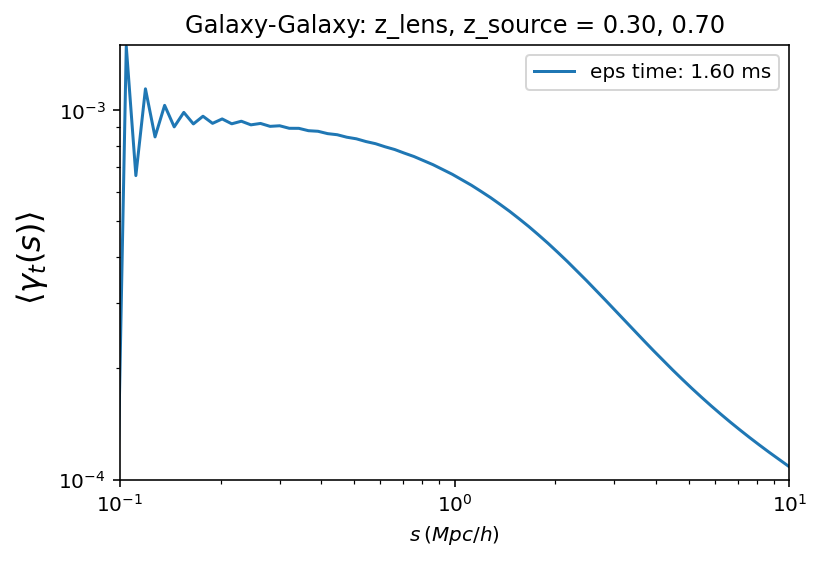

In [ ]:
# plt.xscale('log')
plt.loglog()
plt.plot(s, gmt, label=r'eps time: %.2f ms'%eTimes['Hankl'][-1])
# plt.plot(s, s*s*xi2, label=r'$s^{2}\xi_{2}$ - eps time: %.2f ms'%eTimes['Hankl'][1])
plt.xlim(0.1,10.)
plt.ylim(1e-4,1.5e-3)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r' $\left< \gamma_t (s)\right>$', fontsize=16)
plt.legend()
plt.title('Galaxy-Galaxy: z_lens, z_source = %.2f, %.2f'%(z_lin[1], z_lin[1]+0.4))
plt.show()

If the kmin is greater than 10^{-4} some oscilation patterns appears on the small scales.

## Comparasion Between the Algorithms

In [42]:
from hankel import HankelTransform
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as spline

def hankel_P2xi(k, P, l=0, N=1000, h=0.005):
    l -= 1/2.
    hp = HankelTransform(nu=l, N=N, h=h)        # Create the HankelTransform instance, order zero
    pkk = interp1d(k, P * k ** 1.5, fill_value='extrapolate')
    
    _f = hp.transform(pkk, k, inverse=True,ret_err=False)  # Compute the inverse transform
    f = spline(k, _f) # Define a spline to approximate transform
    r = 2*np.pi/k
    return r, f(k) * (2.0 * np.pi) ** (-1.5) * r ** (-1.5) * (1j) ** l

In [43]:
pk = pk_nonlin[0]
k = kh_nonlin

r, xi_h = hankel_P2xi(k, pk, N=1000, h=0.005)

/global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


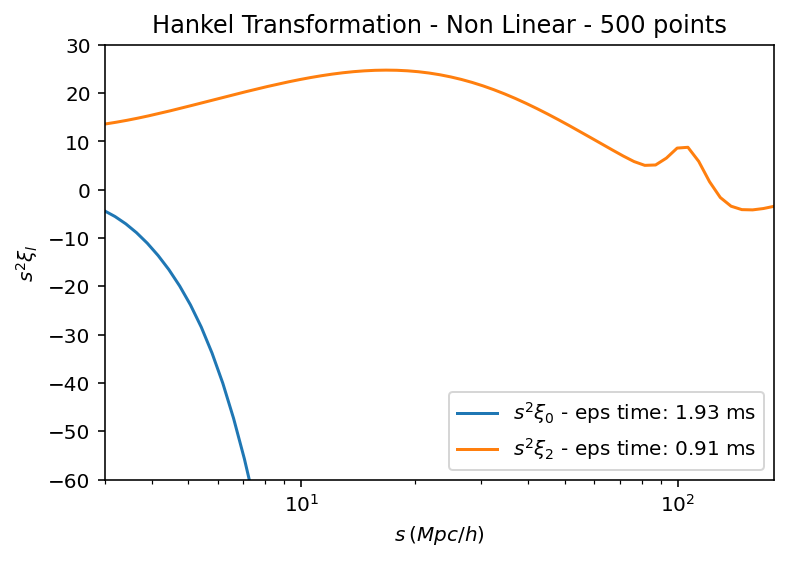

In [44]:
# plt.loglog()
plt.xscale('log')
plt.plot(r, r*r*xi_h, label=r'$s^{2}\xi_{0}$ - eps time: %.2f ms'%eTimes['Hankl'][0])
plt.plot(s, s*s*xi0, label=r'$s^{2}\xi_{2}$ - eps time: %.2f ms'%eTimes['Hankl'][1])
plt.xlim(3,180)
plt.ylim(-60,30)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.title('Hankel Transformation - Non Linear - 500 points')
plt.show()

In [147]:
# pk * k ** 1.5

In [148]:
# Define grid

r = np.linspace(0,1,100)[1:]       # Define a physical grid
k = np.logspace(-3,2,100)           # Define a spectral grid

f    = lambda r : 1/(r**2 + 1)                     # Sample Function
h    = HankelTransform(nu=0,N=1000,h=0.005)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.